<a href="https://colab.research.google.com/github/sttesta3/7506R-1C2024-GRUPO08/blob/santiago/TP2_BayesNaive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Configuración inicial notebook

In [48]:
# General libs
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Modelo
from sklearn.naive_bayes import MultinomialNB

# Metricas
from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score, roc_auc_score

# Entrenamiento
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate, StratifiedKFold


In [27]:
# Configuración token
!pip install kaggle
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

# Si esta mi token literal. Meh, por ahora no tengo nada muy importante ahi
api_token = {"username":"sttesta3","key":"6041f75a7e294a7d093a3c7b47d47766"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c "20241c-7506tp2"
!unzip 20241c-7506tp2.zip
# Tomado de https://stackoverflow.com/questions/56816537/cant-find-kaggle-json-file-in-google-colab

mkdir: cannot create directory ‘/root/.kaggle’: File exists
 29% 9.00M/31.5M [00:00<00:00, 54.4MB/s]
100% 31.5M/31.5M [00:00<00:00, 133MB/s] 


In [44]:
# Carga de data y separación en train-test
ds = pd.read_csv("train.csv")

# Bag of words
# Referencia https://www.kaggle.com/code/vipulgandhi/bag-of-words-model-for-beginners
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(ds.review_es)
vector = vectorizer.transform(ds.review_es)

# Dummies
ds["sentimiento"] = ds["sentimiento"].map({"positivo":0,"negativo":1})

# División en entrenamiento y test
features = "review_es"
target="sentimiento"

X_train, X_test, Y_train, Y_test = train_test_split(vector,
                                                    ds[target].values,
                                                    test_size=0.3,    #30% 0 conjunto de test
                                                    stratify=ds[target].values) #estratificado para mantener proporcion

### Modelo
#### El modelo a entrenar es un naive bayes. Inicialmente probaremos con alpha=1 ( como se explico en la teórica ) y luego se revisará como performa en

In [56]:
# Loop de entrenamiento
CANT_FOLDS_MAXIMA = 105
CANT_FOLDS_MINIMA = 2

NBs = []
resultados = []

# Ajuste bruto
for i in range(CANT_FOLDS_MINIMA,CANT_FOLDS_MAXIMA + 1,10):
  print("#################",i,"FOLDS #################")
  NBcv = MultinomialNB()
  resultados3 = cross_validate(NBcv,X_train, Y_train, cv=StratifiedKFold(n_splits=i),scoring=make_scorer(f1_score),return_estimator=True)
  metricsCV=resultados3['test_score']
  NBs.append( resultados3['estimator'][np.where(metricsCV==max(metricsCV))[0][0]] )
  resultados.append( resultados3['test_score'][np.where(metricsCV==max(metricsCV))[0][0]] )

resultados_test = [ f1_score(Y_test, modelo.predict(X_test)) for modelo in NBs ]

################# 2 FOLDS #################
################# 12 FOLDS #################
################# 22 FOLDS #################
################# 32 FOLDS #################
################# 42 FOLDS #################
################# 52 FOLDS #################
################# 62 FOLDS #################
################# 72 FOLDS #################
################# 82 FOLDS #################
################# 92 FOLDS #################
################# 102 FOLDS #################


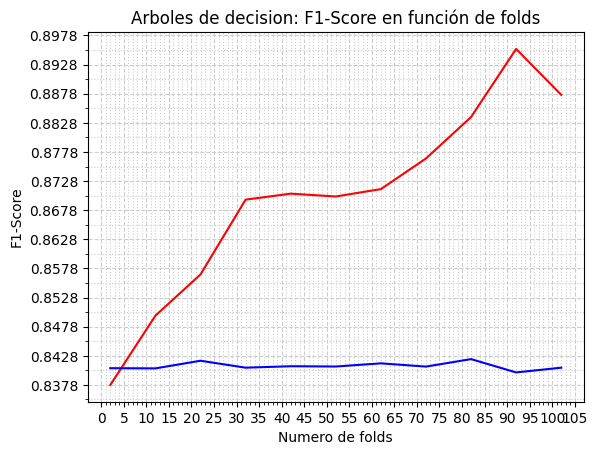

In [57]:
# Graficos de F1-Score en función de Folds para ajuste vruto
fig = plt.figure()
ax = fig.add_subplot()
x_major_ticks = np.arange(0, CANT_FOLDS_MAXIMA + 1, 5)
x_minor_ticks = np.arange(0, CANT_FOLDS_MAXIMA + 1, 1)
y_major_ticks = np.arange(min(resultados) - 0.1, max(resultados) + 0.1, 0.0050)
y_minor_ticks = np.arange(min(resultados) - 0.1, max(resultados) + 0.1, 0.0025)

ax.set_xticks(x_major_ticks)
ax.set_xticks(x_minor_ticks, minor=True)
ax.set_yticks(y_major_ticks)
ax.set_yticks(y_minor_ticks, minor=True)

ax.grid(which='minor', color='#CCCCCC', linestyle=':')
ax.grid(which='major', color='#CCCCCC', linestyle='--')

ax.set_xlabel("Numero de folds")
ax.set_ylabel("F1-Score")
ax.set_title("Arboles de decision: F1-Score en función de folds")

plt.plot(range(CANT_FOLDS_MINIMA,CANT_FOLDS_MAXIMA + 1,10), resultados, label="F1-Score",color="red")
plt.plot(range(CANT_FOLDS_MINIMA,CANT_FOLDS_MAXIMA + 1,10), resultados_test, label="F1-Score",color="blue")

plt.show()

# Referencia utilizada para el gráfico https://stackoverflow.com/questions/24943991/change-grid-interval-and-specify-tick-labels

#### Parecería que entre tres y diez folds esta la cantidad ideal. Utilizaremos treinta debido al leve pico en test entre 20 y 25.
#### De todos modos, parece que aunque el modelo haga un gran overfitting su performance en test se mantiene constante  

In [63]:
# Loop de entrenamiento
CANT_FOLDS_MAXIMA_FINO = 30
CANT_FOLDS_MINIMA = 2

NBs = []
resultados = []

# Ajuste bruto
for i in range(CANT_FOLDS_MINIMA,CANT_FOLDS_MAXIMA_FINO + 1):
  print("#################",i,"FOLDS #################")
  NBcv = MultinomialNB()
  resultados3 = cross_validate(NBcv,X_train, Y_train, cv=StratifiedKFold(n_splits=i),scoring=make_scorer(f1_score),return_estimator=True)
  metricsCV=resultados3['test_score']
  NBs.append( resultados3['estimator'][np.where(metricsCV==max(metricsCV))[0][0]] )
  resultados.append( resultados3['test_score'][np.where(metricsCV==max(metricsCV))[0][0]] )

resultados_test = [ f1_score(Y_test, modelo.predict(X_test)) for modelo in NBs ]

################# 2 FOLDS #################
################# 3 FOLDS #################
################# 4 FOLDS #################
################# 5 FOLDS #################
################# 6 FOLDS #################
################# 7 FOLDS #################
################# 8 FOLDS #################
################# 9 FOLDS #################
################# 10 FOLDS #################
################# 11 FOLDS #################
################# 12 FOLDS #################
################# 13 FOLDS #################
################# 14 FOLDS #################
################# 15 FOLDS #################
################# 16 FOLDS #################
################# 17 FOLDS #################
################# 18 FOLDS #################
################# 19 FOLDS #################
################# 20 FOLDS #################
################# 21 FOLDS #################
################# 22 FOLDS #################
################# 23 FOLDS #################
################# 

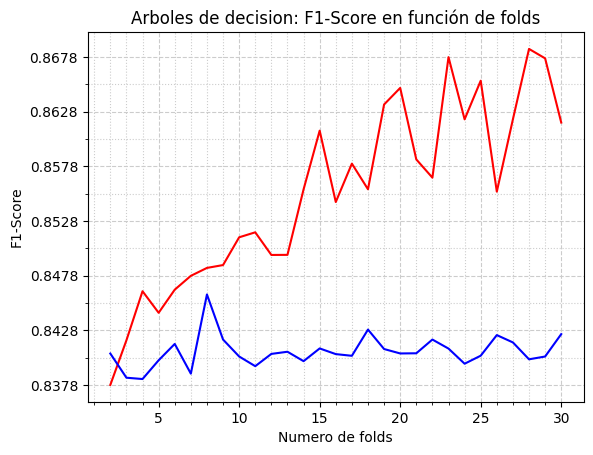

In [64]:
# Graficos de F1-Score en función de Folds para ajuste vruto
fig = plt.figure()
ax = fig.add_subplot()
x_major_ticks = np.arange(0, CANT_FOLDS_MAXIMA_FINO + 1, 5)
x_minor_ticks = np.arange(0, CANT_FOLDS_MAXIMA_FINO + 1, 1)
y_major_ticks = np.arange(min(resultados) - 0.1, max(resultados) + 0.1, 0.0050)
y_minor_ticks = np.arange(min(resultados) - 0.1, max(resultados) + 0.1, 0.0025)

ax.set_xticks(x_major_ticks)
ax.set_xticks(x_minor_ticks, minor=True)
ax.set_yticks(y_major_ticks)
ax.set_yticks(y_minor_ticks, minor=True)

ax.grid(which='minor', color='#CCCCCC', linestyle=':')
ax.grid(which='major', color='#CCCCCC', linestyle='--')

ax.set_xlabel("Numero de folds")
ax.set_ylabel("F1-Score")
ax.set_title("Arboles de decision: F1-Score en función de folds")

plt.plot(range(CANT_FOLDS_MINIMA,CANT_FOLDS_MAXIMA_FINO + 1), resultados, label="F1-Score",color="red")
plt.plot(range(CANT_FOLDS_MINIMA,CANT_FOLDS_MAXIMA_FINO + 1), resultados_test, label="F1-Score",color="blue")

plt.show()

# Referencia utilizada para el gráfico https://stackoverflow.com/questions/24943991/change-grid-interval-and-specify-tick-labels

##### La cantidad de folds ideal, con una performance muy similar entre entrenamiento y prueba es de ocho folds.